In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# End to End Multiclass Surface Defect Dectection

## Problem Definition
The goal of this project is to build a deep learning model that can automatically classify surface defects on steel. Surface defects occur frequently in industrial production and can affect the quality and safety of the final product. The dataset used in this project contains six common types of steel surface defects: crazing, inclusion, patches, pitted surface, rolled-in scale, and scratches. The model will be trained to distinguish between these defect categories based on images of steel surfaces.

## Data
The data I am using is from kaggle NEU Surface Defect Database:

https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database

## Evaluation
The model will be evaluated using accuracy, precision, recall, and F1-score for each defect class, as well as their macro averages. A confusion matrix will be used to analyze class-wise misclassifications. To validate robustness, 5-fold cross-validation will be performed, and visualization techniques such as Grad-CAM will be applied to interpret model predictions

## features
Six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc). The database includes 1,800 grayscale images: 300(split into 240 images for training and 60 images for testing.) samples each of six different kinds of typical surface defects.

In [22]:
train_image = "/kaggle/input/neu-surface-defect-database/NEU-DET/train/images/"
os.listdir(train_image)

['inclusion',
 'scratches',
 'pitted_surface',
 'patches',
 'crazing',
 'rolled-in_scale']

In [23]:
defect_images = []
defect_labels = []
for defect in os.listdir(train_image):
    defect_type = os.path.join(train_image, defect)
    for img in os.listdir(defect_type):
        images = os.path.join(defect_type, img)
        defect_images.append(images) 
        defect_labels.append(defect)


In [24]:
## list of defect filepaths and its corresponding labels
len(defect_images), len(defect_labels)

(1440, 1440)

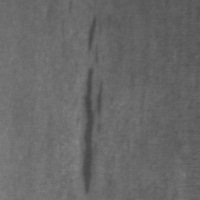

In [25]:
from IPython.display import Image
Image(defect_images[90])


## Preprocessing Images and Label

In [26]:
# getting the unique labels
unique_label = np.unique(defect_labels)
defect_labels[0] == unique_label


array([False,  True, False, False, False, False])

# rename image path and label to X and y and split them to training and validation set
from sklearn.model_selection import train_test_split
X = defect_images
y = defect_labels

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

y_train_bool = np.array([label == unique_label for label in y_train]).astype(int)
y_valid_bool = np.array([label == unique_label for label in y_valid]).astype(int)

y_train_bool.shape, y_valid_bool.shape


In [29]:
from sklearn.model_selection import StratifiedKFold
X = np.array(defect_images)
y = np.array(defect_labels)


# set up stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_valid = X[train_idx], X[val_idx]
    y_train, y_valid = y[train_idx], y[val_idx]

    # one-vs-all boolean encoding for this fold
    y_train_bool = np.array([label == unique_label for label in y_train]).astype(int)
    y_valid_bool = np.array([label == unique_label for label in y_valid]).astype(int)

    print("Train shape:", X_train.shape, y_train_bool.shape)
    print("Valid shape:", X_valid.shape, y_valid_bool.shape)





--- Fold 1 ---
Train shape: (1152,) (1152, 6)
Valid shape: (288,) (288, 6)

--- Fold 2 ---
Train shape: (1152,) (1152, 6)
Valid shape: (288,) (288, 6)

--- Fold 3 ---
Train shape: (1152,) (1152, 6)
Valid shape: (288,) (288, 6)

--- Fold 4 ---
Train shape: (1152,) (1152, 6)
Valid shape: (288,) (288, 6)

--- Fold 5 ---
Train shape: (1152,) (1152, 6)
Valid shape: (288,) (288, 6)


In [8]:
# preprocess the image path
IMG_SIZE = 224
import tensorflow as tf
import tensorflow_hub as hub
def preprocess_image(image_path, img_size=IMG_SIZE):
    # tensorflow reading the image file
    image = tf.io.read_file(image_path)
    # convert the image to tensor and assign the 3 color channel (red, green, blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # convert the color channels from 0-255 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    # resize the image 
    image = tf.image.resize(image, [img_size, img_size])
    return image
    

2025-09-02 11:51:19.566981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756813879.945945      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756813880.051756      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# create a tuple of the imagepath and label
def get_tuple(image_path, label):
    image = preprocess_image(image_path)
    return image, label

In [106]:
# create data batches 
BATCH_SIZE = 32
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Create data batches, shuffle for only training dataset.
    """
    if test_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data.map(get_tuple).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return data_batch
    elif valid_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data.map(get_tuple).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return data_batch
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(get_tuple).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return data_batch
        

In [11]:
# get training data and valid data i will be feeding my model
train_data = create_data_batches(X_train, y=y_train_bool)
valid_data = create_data_batches(X_valid, y=y_valid_bool, valid_data=True)
train_data, valid_data

y_train_bool

I0000 00:00:1756813900.396543      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756813900.397312      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


array([[0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0]])

In [12]:
train_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))

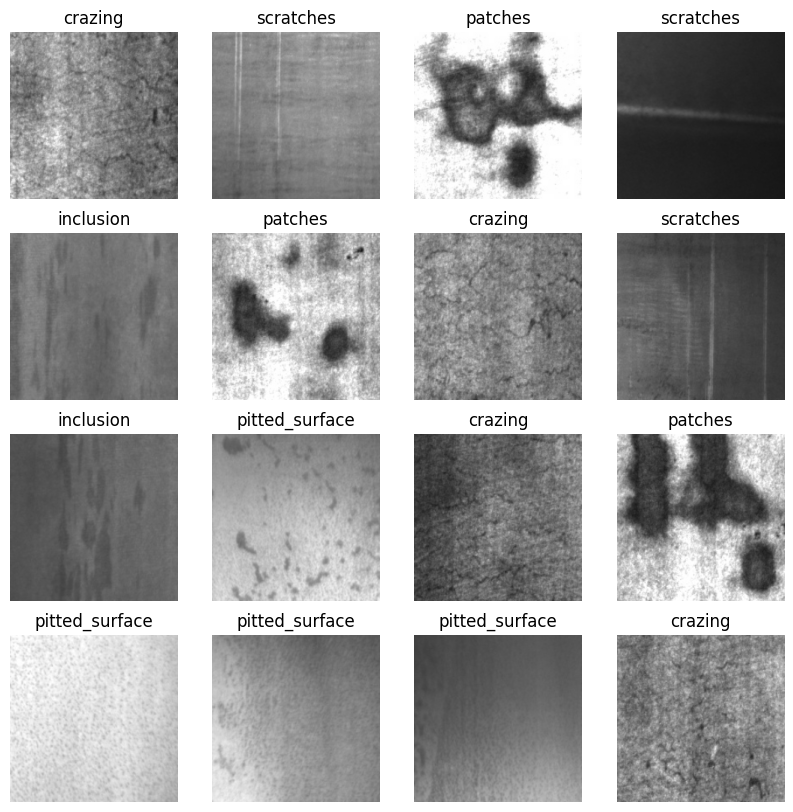

In [13]:
## view the preprocessed image with corresponding label
from matplotlib.pyplot import imshow, imread
import matplotlib.pyplot as plt
train_image, train_label = next(train_data.as_numpy_iterator())
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()
for i in range(16):
    axes[i].imshow(train_image[i])
    axes[i].axis("off")
    axes[i].set_title(f"{unique_label[train_label[i].argmax()]}")
    

In [14]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(unique_label)
MODEL_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
INPUT_SHAPE[1:]

[224, 224, 3]

In [15]:
1e-4

0.0001

In [16]:
# create model using transfer learning
import tf_keras as keras

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomTranslation(0.1, 0.1)
])


def create_model(model_url=MODEL_URL, output_shape=OUTPUT_SHAPE, input_shape=INPUT_SHAPE):
    model = keras.Sequential([
        data_augmentation,
        hub.KerasLayer(model_url, trainable=True, input_shape=input_shape[1:]),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=output_shape, activation="softmax", kernel_regularizer=keras.regularizers.l2(0.04))
    ])

    model.compile(
        loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer = keras.optimizers.Adam(1e-5),
        metrics = ["accuracy"]
    )

    model.build(input_shape)

    return model
    

In [17]:
mv2_model = create_model()
mv2_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2265670 (8.64 MB)
Trainable params: 2231558 (8.51 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [18]:
# Create callbacks (TensorBoard and EarlyStopping)
%load_ext tensorboard


In [19]:
import datetime
def create_tensorboard():
    log_dir = os.path.join("/kaggle/working/log/",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return keras.callbacks.TensorBoard(log_dir, histogram_freq=1, write_graph=True, update_freq='batch')

tensorboard = create_tensorboard()

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)


## Train the model with the data and evaluate 

In [20]:


checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/best_model.keras",  # full path
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

EPOCHS = 50
mv2_model.fit(x=train_data,
         validation_data=valid_data,
         validation_freq=1,
         epochs = EPOCHS,
         callbacks = [tensorboard, early_stopping, checkpoint]
         )

Epoch 1/50


I0000 00:00:1756813931.022041      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756813933.945110      98 service.cc:148] XLA service 0x794637e50af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756813933.946389      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756813933.946410      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756813934.206379      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 [==============================] - ETA: 0s - loss: 2.5409 - accuracy: 0.2457
Epoch 1: val_loss improved from inf to 2.68805, saving model to /kaggle/working/best_model.keras
36/36 [==============================] - 54s 259ms/step - loss: 2.5409 - accuracy: 0.2457 - val_loss: 2.6880 - val_accuracy: 0.2847
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 2.0706 - accuracy: 0.4540
Epoch 2: val_loss improved from 2.68805 to 2.64047, saving model to /kaggle/working/best_model.keras
36/36 [==============================] - 8s 215ms/step - loss: 2.0706 - accuracy: 0.4540 - val_loss: 2.6405 - val_accuracy: 0.3299
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 1.7457 - accuracy: 0.6250
Epoch 3: val_loss improved from 2.64047 to 2.50078, saving model to /kaggle/working/best_model.keras
36/36 [==============================] - 8s 213ms/step - loss: 1.7457 - accuracy: 0.6250 - val_loss: 2.5008 - val_accuracy: 0.3264
Epoch 4/50
36/36 [==================

In [31]:
mv2_model.evaluate(valid_data)

9/9 [==============================] - 0s 40ms/step - loss: 1.1098 - accuracy: 0.9514


[1.1097880601882935, 0.9513888955116272]

In [49]:
best_model_mv2 = keras.models.load_model("/kaggle/working/best_model.keras", custom_objects={"KerasLayer": hub.KerasLayer})

In [50]:
# unbatch valid data to get its images and labels (ready for comparison with the unpcoming predicted labels by the model)
valid_images = []
valid_labels = []
for image, label in valid_data.unbatch().as_numpy_iterator():
    valid_images.append(image)
    valid_labels.append(label)

In [51]:
len(valid_labels)

288

In [52]:
# model predict the labels from the validation images
mv2_prediction = best_model_mv2.predict(valid_data)

9/9 [==============================] - 1s 37ms/step


In [54]:
len(mv2_prediction)

288

In [64]:
# visualize the prediction
def visualize_preds(images, true_prob, pred_prob, n):
    

    plt.figure(figsize=(10, 10))
    for i in range(10):
        image = images[n+i]
        true_label = unique_label[true_prob[n+i].argmax()]
        pred_label = unique_label[pred_prob[n+i].argmax()]
        conf = round((np.max(pred_prob[n+i]) * 100), 2)

        if true_label == pred_label:
            color = "green"
        else:
            color = "red"
    
        plt.subplot(5, 2, i+1)
        plt.imshow(image)
        plt.title(f"{true_label}, {conf}, {pred_label}", color=color)

    plt.tight_layout()
    plt.show()


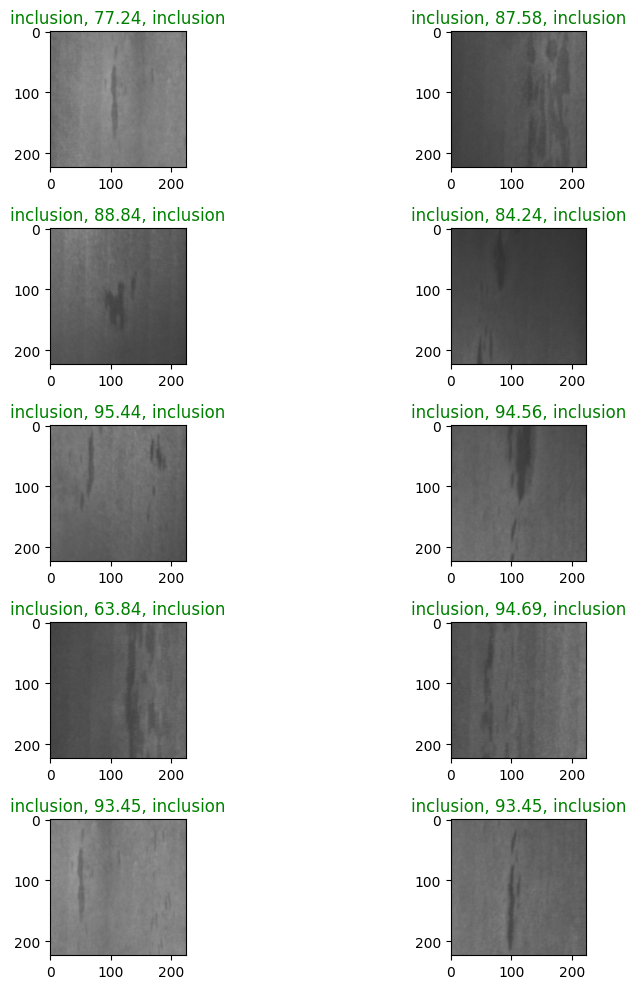

In [67]:
visualize_preds(valid_images, valid_labels, mv2_prediction, 10)

In [134]:
# visualize predictions of the top 3 probabilities
def top_3_pred(images, pred_prob, true_prob, n):
    true_label = unique_label[true_prob[n].argmax()]
    pred_label = unique_label[pred_prob[n].argmax()]
    image = images[n]
    conf = round((np.max(pred_prob[n]) * 100), 2)
    

    top_3_indexes = pred_prob[n].argsort()[-3:][::-1]
    top_3_values = pred_prob[n][top_3_indexes]
    top_3_labels = unique_label[top_3_indexes]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    top_3 = plt.bar(np.arange(len(top_3_labels)), top_3_values, color="grey")
    plt.xticks(np.arange(len(top_3_labels)), labels=top_3_labels, rotation="horizontal")

    if np.isin(true_label, top_3_labels):
        top_3[np.argmax(true_label==top_3_labels)].set_color("green")
    else:
        pass
    plt.ylabel("Probabilities")
    plt.title("Top 3 Predictions")
    
    plt.subplot(1, 2, 2)
    if true_label == pred_label:
        color = "green"
    else:
        color = "red"
    plt.imshow(image)
    plt.title(f"{true_label}, {conf}, {pred_label}", color=color)
   
    
    plt.tight_layout()
    plt.show()
   
    

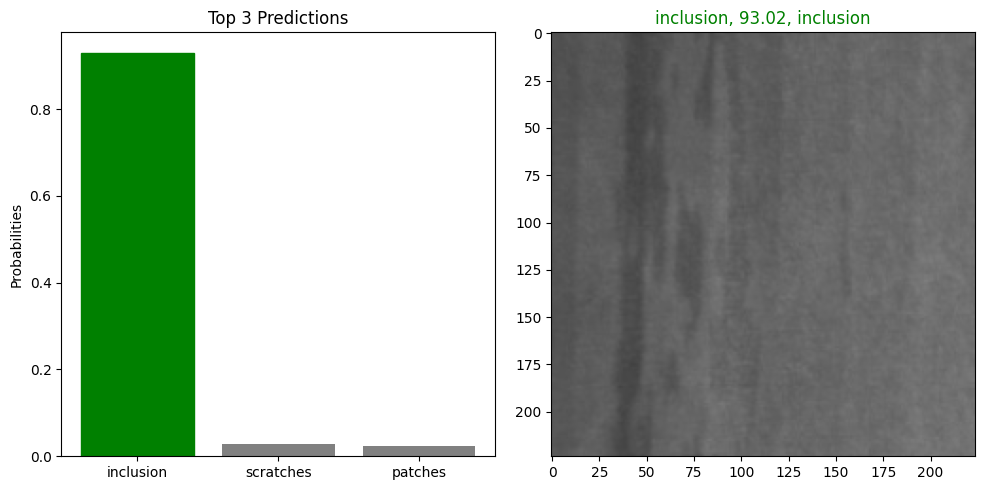

In [135]:
top_3_pred(valid_images, mv2_prediction, valid_labels, 5)

In [136]:
def top_3_preds_batch(images, pred_prob, true_prob, n, batch_size=5):
    """
    Visualize top 3 predictions for a batch of images.
    
    images: numpy array of images
    pred_prob: numpy array of model prediction probabilities
    true_prob: one-hot encoded true labels
    n: starting index
    batch_size: number of images to visualize
    """
    for i in range(batch_size):
        idx = n + i
        true_label = unique_label[true_prob[idx].argmax()]
        pred_label = unique_label[pred_prob[idx].argmax()]
        image = images[idx]
        conf = round((np.max(pred_prob[idx]) * 100), 2)

        top_3_indexes = pred_prob[idx].argsort()[-3:][::-1]
        top_3_values = pred_prob[idx][top_3_indexes]
        top_3_labels = unique_label[top_3_indexes]

        plt.figure(figsize=(8, 4))
        
        # Bar chart of top 3 predictions
        plt.subplot(1, 2, 1)
        bars = plt.bar(np.arange(len(top_3_labels)), top_3_values, color="grey")
        plt.xticks(np.arange(len(top_3_labels)), labels=top_3_labels, rotation=0)
        true_idx = np.where(top_3_labels == true_label)[0]
        if len(true_idx) > 0:
            bars[true_idx[0]].set_color("green")
        plt.ylabel("Probability")
        plt.title("Top 3 Predictions")
        
        # Image with predicted label
        plt.subplot(1, 2, 2)
        color = "green" if true_label == pred_label else "red"
        plt.imshow(image)
        plt.title(f"{true_label}, {conf}%, {pred_label}", color=color)
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()


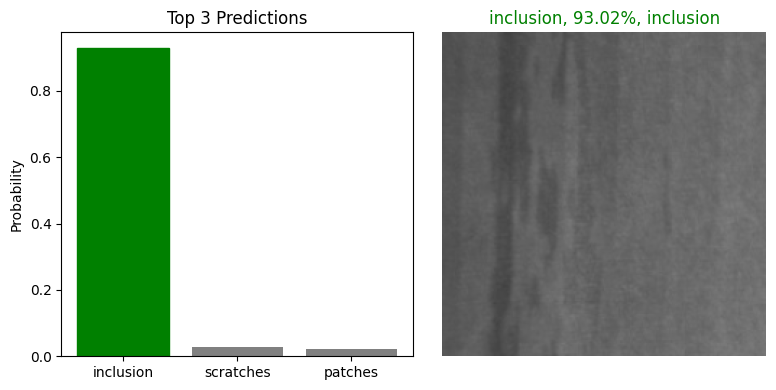

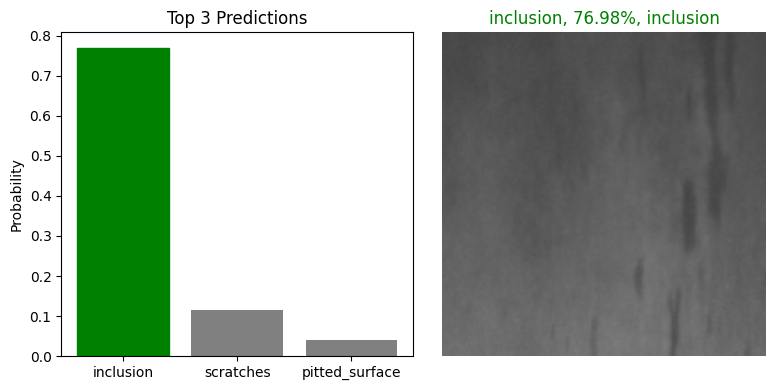

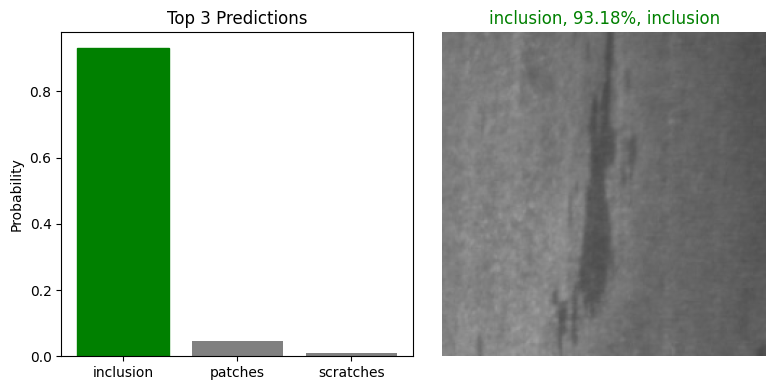

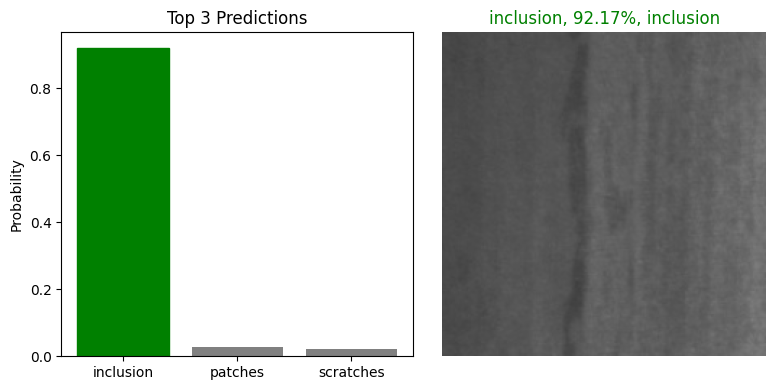

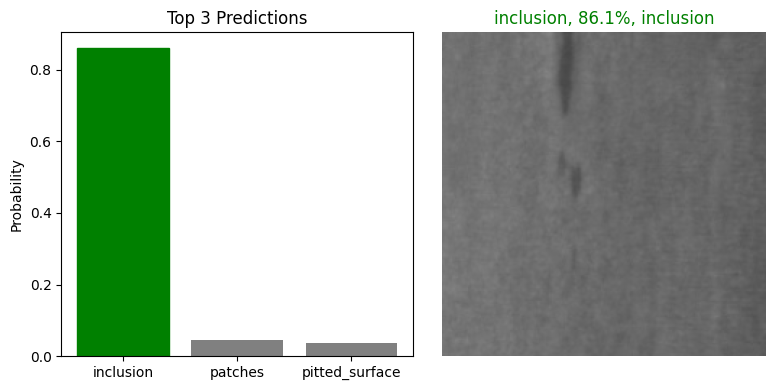

In [137]:
top_3_preds_batch(valid_images, mv2_prediction, valid_labels, 5)

# Test the model on the new test dataset

In [95]:
# get the test images and label
test_path = "/kaggle/input/neu-surface-defect-database/NEU-DET/validation/images/"
os.listdir(test_path)

['inclusion',
 'scratches',
 'pitted_surface',
 'patches',
 'crazing',
 'rolled-in_scale']

In [99]:
test_images = []
test_labels = []
for defect in os.listdir(test_path):
    defect_types = os.path.join(test_path, defect)
    for img in os.listdir(defect_types):
        images = os.path.join(defect_types, img)
        test_images.append(images)
        test_labels.append(defect)
        
   

In [111]:
test_prob = np.array([label == unique_label for label in test_labels]).astype(int)
len(test_images), len(test_prob), len(test_labels)

(360, 360, 360)

In [112]:
test_data = create_data_batches(test_images, y=test_prob, test_data=True)
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

In [113]:
test_predictions = best_model_mv2.predict(test_data)

12/12 [==============================] - 0s 36ms/step


In [120]:
test_image = []
test_prob = []
for image, label in test_data.unbatch().as_numpy_iterator():
    test_image.append(image)
    test_prob.append(label)

testtrue_label = np.argmax(test_prob, axis=1)

testpred_label = np.argmax(test_predictions, axis=1)

In [121]:
# Evaluate the test predictions
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(testtrue_label, testpred_label)
precision = precision_score(testtrue_label, testpred_label, average="weighted")
recall = recall_score(testtrue_label, testpred_label, average="weighted")

print(f"Accuracy Score: {accuracy:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score: {recall:.4f}")

Accuracy Score: 0.9639
Precision Score: 0.9650
Recall Score: 0.9639


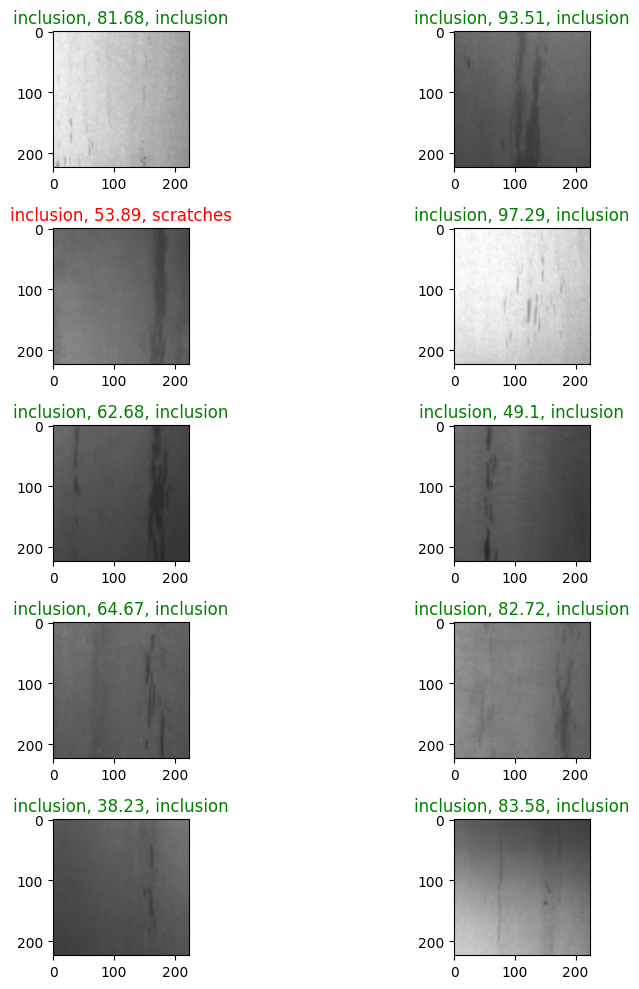

In [144]:
visualize_preds(test_image, test_prob, test_predictions, 10)

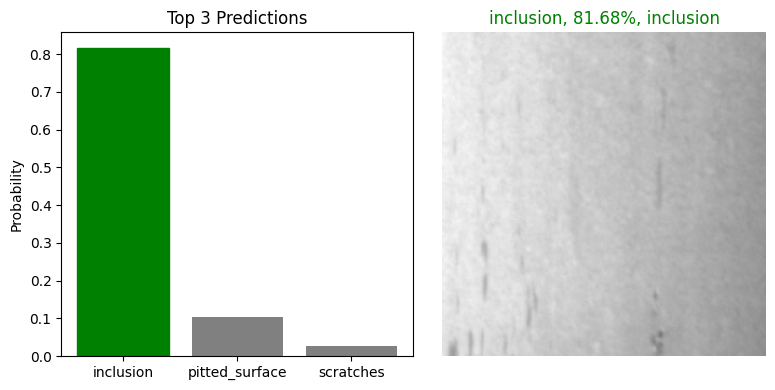

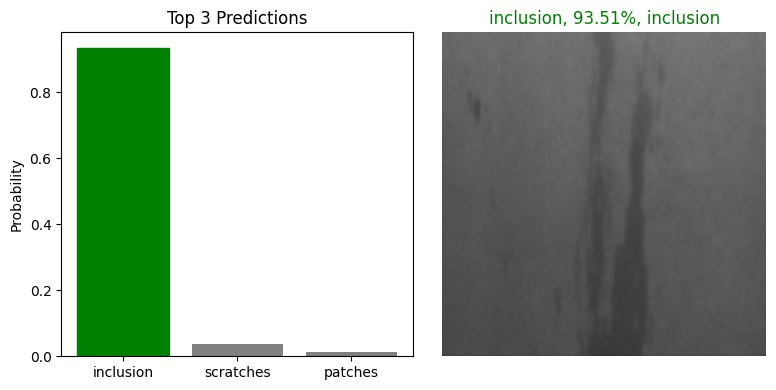

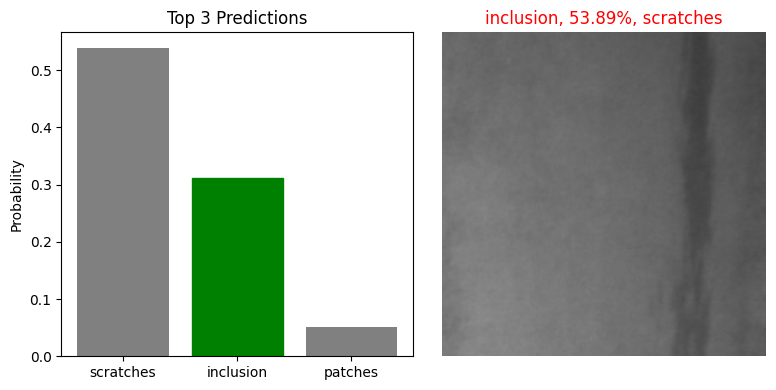

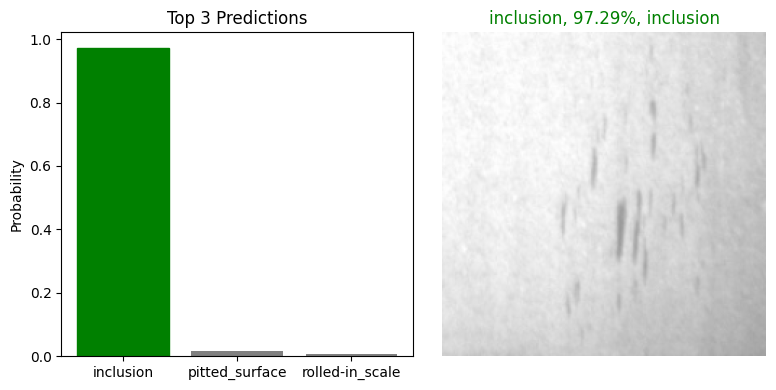

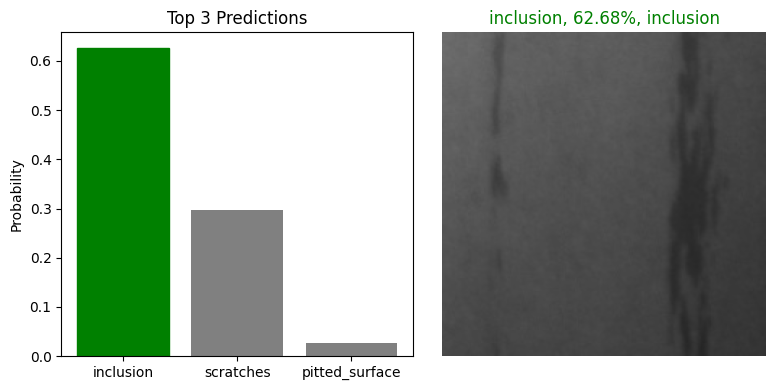

In [145]:
top_3_preds_batch(test_image, test_predictions, test_prob, 10)

In [146]:
# Convert true labels to integer indices if necessary
true_label_indices = np.array([np.where(unique_label == l)[0][0] for l in test_labels])

# Compute per-class precision and recall
per_class_precision = precision_score(true_label_indices, testpred_label, average=None)
per_class_recall = recall_score(true_label_indices, testpred_label, average=None)

# Display
for i, cls in enumerate(unique_label):
    print(f"{cls}: Precision = {per_class_precision[i]:.4f}, Recall = {per_class_recall[i]:.4f}")


crazing: Precision = 0.9500, Recall = 0.9500
inclusion: Precision = 0.9828, Recall = 0.9500
patches: Precision = 0.9524, Recall = 1.0000
pitted_surface: Precision = 1.0000, Recall = 0.8833
rolled-in_scale: Precision = 0.9524, Recall = 1.0000
scratches: Precision = 0.9524, Recall = 1.0000


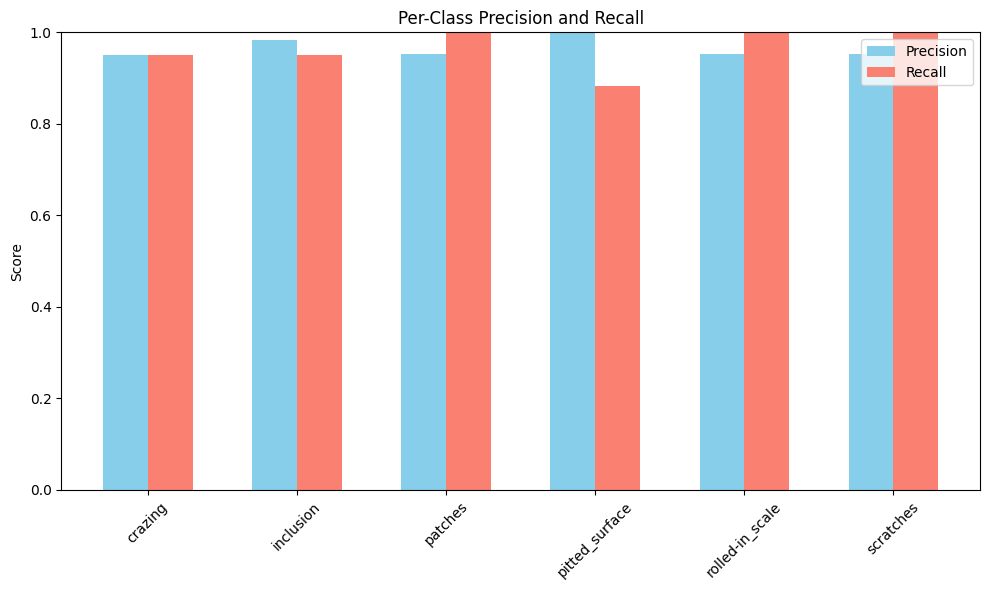

In [147]:
x = np.arange(len(unique_label))  # label indices

plt.figure(figsize=(10,6))
plt.bar(x - 0.15, per_class_precision, width=0.3, label='Precision', color='skyblue')
plt.bar(x + 0.15, per_class_recall, width=0.3, label='Recall', color='salmon')
plt.xticks(x, unique_label, rotation=45)
plt.ylabel("Score")
plt.ylim(0,1)
plt.title("Per-Class Precision and Recall")
plt.legend()
plt.tight_layout()
plt.show()
